# Canceling and Selecting Partials from Musical Tones Using Fractional-Delay Filters

Heidi-Maria Lehtonen, Vesa Välimäki and Timo I. Laakso

- Write a compact summary (approx. 2-3 pages) and your own thoughts
- Implement and explore some algorithm presented in the paper using Matlab
- Report your findings

The paper claims that one can use fractional-delay filters to cancel and select partials from musical signals. Such filters are variations of inverse transfer function of a comb filter. The idea of canceling harmonics from a musical signal using digital filters was first introduced by Moorer in 1974, where Moorer published papers about pitch detection and analyzing music data for additive synthesis. 

This paper is an extended study of Välimäki et al. which claimed that **the delay line in the inverse comb filter(ICF) can be replaced with a high-order fractional-delay filter** to obtain very accurate cancellation of neighboring harmonics to select a single harmonic or to extract the residual signal by canceling all harmonics.

Compared to general FFT-based techniques(McAulay and Quatieri 1986; Serra 1989; Serra and Smith 1990), which is a popular tool for signal decomposition, fractional-delay filters have smaller number of parameters, and one can design filter coefficients in closed form. The decomposition results in time-domain directly thus, no separate transformation is required.

There have been multiple efforts on analyzing the harmonic structure of musical signals; wavelets(Evangelista 1993) and high resolution tracking methods(Badeau, David, and Richard 2006). While these methods deliver very high frequency estimation accuracy, they are computationally expensive.  Fractional-delay filters estimate both frequency and amplitude with high accuracy, low cost and easy to use.



In [36]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = 'Ubuntu'
# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18   # Time and Hz, i.e. labels
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18  # Time(x) tick values
plt.rcParams['ytick.labelsize'] = 18  # Hz(y) tick values
plt.rcParams['legend.fontsize'] = 17
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 20   # Title font

from scipy.signal import freqz, lfilter

from asp import config
import numpy as np
from asp.core import read_wave, Wave
from IPython.display import Audio

Our test dataset paths

In [5]:
config.paths.data

['/Users/parks1/asp/data/c2e2f2.wav',
 '/Users/parks1/asp/data/c2e2.wav',
 '/Users/parks1/asp/data/92002__jcveliz__violin-origional.wav',
 '/Users/parks1/asp/data/c2e2g2.wav']

In [6]:
# Let's listen to one of them
c2e2f2 = read_wave(config.paths.data[0])
c2e2f2.make_audio()

Let's remove f2, i.d. 174.614 Hz using truncated Lagrange design method.

$$h_{\mathrm{TL}}(n)=\prod_{k=0 \atop k \neq n+K_{1}}^{M} \frac{D-k}{n+K_{1}-k} \quad \text{for $n = 0,1,2,\ldots,N$} $$

- $M$: prototype filter order ($M > N$)
- $K_1$: number of coefficients that are discarded from either end of the impulse response

In [30]:
D = 174.614  # Frequency to remove
N = 160     # Chunk size
M = 7*N     # Filter order
d = 0.5     # Fractional delay parameter
K1 = 0

def lagrange_truncated(chunk):
    h = np.zeros(chunk.shape)
    
    for n in range(chunk.size):
        """Calculate largrange polynomial in vectorized form"""
        k_array = np.arange(M)
        # Skip the k = n + K1 in order to avoid zero division error
        k_array = np.concatenate(
            (k_array[:n+K1],
            k_array[n+K1+1:])
        )
        
        h_tl = np.prod((D - k_array) / (n + K1 - k_array))

        h[n] = chunk[n] * h_tl
            
    return h


def fractional_delay_truncated_lagrange(ys):
    filtered = np.zeros(ys.shape)
    for i in range(0, len(ys), N):
        chunk = ys[i:N+i]
        filtered[i:N+i] += lagrange_truncated(chunk)
        
    return filtered
    
c2e2_ys = fractional_delay_truncated_lagrange(c2e2f2.ys)

In [38]:
D = 174.614  # Frequency to remove
N = 160     # Chunk size
M = 7*N     # Filter order
d = 0.5     # Fractional delay parameter
K1 = 20

def lagrange_truncated():
    zs = []
    
    for n in range(N):
        """Calculate largrange polynomial in vectorized form"""
        k_array = np.arange(M)
        # Skip the k = n + K1 in order to avoid zero division error
        k_array = np.concatenate(
            (k_array[:n+K1],
            k_array[n+K1+1:])
        )
        
        h_tl = np.prod((D - k_array) / (n + K1 - k_array))
        zs.append(h_tl)
            
    return zs


In [39]:
filter = lagrange_truncated()

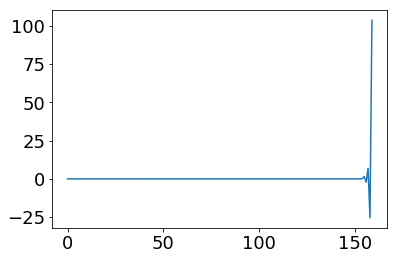

In [40]:
plt.plot(filter)

In [31]:
Audio(c2e2_ys, rate=44100)

In [28]:
np.all(c2e2_ys == fc2)

True

In [22]:
fc2 = np.concatenate(filtered2)

In [9]:
f = filtered[:]

In [10]:
fc = np.concatenate(f)

In [23]:
fc.shape, fc2.shape

((262011,), (262011,))

In [25]:
np.alltrue(fc == fc2)

True

In [13]:
c2e2f2.ys.shape

(262011,)

In [15]:
Audio(fc, rate=44100)